# Foursquare Location Matching

The data presented here comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. 

My task is to determine which place entries describe the same point-of-interest. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.

## Libraries installing and dataset downloading

In [2]:
%%capture

! pip install kaggle
! pip install numpy
! pip install pandas
! pip install sklearn
! pip install matplotlib
! pip install Levenshtein
! pip install .\GDAL-3.4.3-cp310-cp310-win_amd64.whl
! pip install .\Fiona-1.8.21-cp310-cp310-win_amd64.whl
! pip install geopandas

In [3]:
# Flag to force to reload dataset
RELOAD = False

In [4]:
import os

# import Kaggle API to load dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# initialize Kaggle API
api = KaggleApi()
api.authenticate()

# download dataset from Kaggle to data folder
data_path = 'data'
api.competition_download_files('foursquare-location-matching', data_path, force=RELOAD, quiet=False)
# save filename: !ATTENTION! : it may not be wroking if many files are in folders
# then just name it manually 
dataset_file_name = os.listdir(data_path)[0]

foursquare-location-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


### Data description and loading

The data presented here comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. Your task is to determine which place entries describe the same point-of-interest. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.

#### Training Data

* *train.csv* - The training set, comprising eleven attribute fields for over one million place entries, together with:
    * `id` - A unique identifier for each entry.
    * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI.
* *pairs.csv* - A pregenerated set of pairs of place entries from train.csv designed to improve detection of matches. You may wish to generate additional pairs to improve your model's ability to discriminate POIs.
    * `match` - Whether (`True` or `False`) the pair of entries describes a common POI.

#### Example Test Data

To help you author submission code, we include a few example instances selected from the test set. When you submit your notebook for scoring, this example data will be replaced by the actual test data. The actual test set has approximately 600,000 place entries with POIs that are distinct from the POIs in the training set.

* *test.csv* - A set of place entries with their recorded attribute fields, similar to the training set.
* *sample_submission.csv* - A sample submission file in the correct format.
    * `id` - The unique identifier for a place entry, one for each entry in the test set.
    * `matches` - A space delimited list of IDs for entries in the test set matching the given ID. Place entries always self-match.

In [5]:
# import libraries to work with paths and to read zipped file, as was downloaded from Kaggle
from zipfile import ZipFile
# import pandas for EDA
import pandas as pd

# Read train dataset (train.csv) to pandas DataFrame named df: it will be used for analysis
df = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('train.csv'))

df_pairs = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('pairs.csv'))

# Read test dataset (test.csv), to pandas DataFrame named df_validation. It will be used only to generate final predictions, which will be submitted
df_validation = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('test.csv'))
# finally, we will download example of submission (there are no correct predictions there, it is just an example)
df_subm_example = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('sample_submission.csv'))

In [6]:
# Check, that all dataframes are loaded and have correct shapes
print(f'Shape of df: {str(df.shape)}')
print(f'Shape of df_pairs: {str(df_pairs.shape)}')
print(f'Shape of df_validation: {str(df_validation.shape)}')
print(f'Shape of df_subm_example: {str(df_subm_example.shape)}')

Shape of df: (1138812, 13)
Shape of df_pairs: (578907, 25)
Shape of df_validation: (5, 12)
Shape of df_subm_example: (5, 2)


## Exploratory data analysis

First, let's take a look on `df`, analyse it's structure and data

In [7]:
df.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [8]:
print(f'Number of records in df: {df.shape[0]}')
print(f'Number of columns in df: {df.shape[1]}')

Number of records in df: 1138812
Number of columns in df: 13


In [9]:
print(f'Names of columns in df: {list(df.columns)}')

Names of columns in df: ['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest']


DataFrame `df` contains entries of POIs. 
Let's go through the columns to describe them

First, let's create helper function `col_describe` to use it for different columns

In [10]:
def col_describe(column_name, df=df):
    t = df[column_name].dtype
    n = len(df[column_name])
    nu = df[column_name].nunique()
    n_na = df.isna()[column_name].sum()
    print(f"Type of `{column_name}` column in `df` is: {t}")
    if (t == object):
        print("Object in pandas means string")
    
    print(f"Number of NaNs in `{column_name}` column: {n_na}, which is {n_na/n * 100}% from total number of values")
    
    print(f"Total amount of records (column `{column_name}`) is {n} and number of unique values is {nu}")
    print(f"{nu / n * 100}% of the values in `{column_name}` column are unique")


Column `id` is a unique identifier of the entry

In [11]:
col_describe('id')

Type of `id` column in `df` is: object
Object in pandas means string
Number of NaNs in `id` column: 0, which is 0.0% from total number of values
Total amount of records (column `id`) is 1138812 and number of unique values is 1138812
100.0% of the values in `id` column are unique


Column `name` is the name of POI entry

In [12]:
col_describe('name')

Type of `name` column in `df` is: object
Object in pandas means string
Number of NaNs in `name` column: 1, which is 8.781080634907254e-05% from total number of values
Total amount of records (column `name`) is 1138812 and number of unique values is 842086
73.9442506752651% of the values in `name` column are unique


Columns `latitude` and `longitude` are geographical coordinates of the reported location

In [13]:
col_describe('latitude')
print('\n')
col_describe('longitude')

Type of `latitude` column in `df` is: float64
Number of NaNs in `latitude` column: 0, which is 0.0% from total number of values
Total amount of records (column `latitude`) is 1138812 and number of unique values is 1121701
98.49746929256102% of the values in `latitude` column are unique


Type of `longitude` column in `df` is: float64
Number of NaNs in `longitude` column: 0, which is 0.0% from total number of values
Total amount of records (column `longitude`) is 1138812 and number of unique values is 1080273
94.85964320713164% of the values in `longitude` column are unique


Columns `address`, `city`, `state`, `zip`, `country` are describing address of the reported location

In [14]:
col_describe('address')
print('\n')
col_describe('city')
print('\n')
col_describe('state')
print('\n')
col_describe('zip')
print('\n')
col_describe('country')

Type of `address` column in `df` is: object
Object in pandas means string
Number of NaNs in `address` column: 396621, which is 34.827609824975504% from total number of values
Total amount of records (column `address`) is 1138812 and number of unique values is 558154
49.01195280696024% of the values in `address` column are unique


Type of `city` column in `df` is: object
Object in pandas means string
Number of NaNs in `city` column: 299189, which is 26.272027340772663% from total number of values
Total amount of records (column `city`) is 1138812 and number of unique values is 68105
5.980354966403585% of the values in `city` column are unique


Type of `state` column in `df` is: object
Object in pandas means string
Number of NaNs in `state` column: 420586, which is 36.93199579913102% from total number of values
Total amount of records (column `state`) is 1138812 and number of unique values is 17596
1.5451189485182804% of the values in `state` column are unique


Type of `zip` column in

Columns `url`, `phone` of the POI

In [15]:
col_describe('url')
print('\n')
col_describe('phone')

Type of `url` column in `df` is: object
Object in pandas means string
Number of NaNs in `url` column: 871088, which is 76.4909396810009% from total number of values
Total amount of records (column `url`) is 1138812 and number of unique values is 171222
15.035141884700899% of the values in `url` column are unique


Type of `phone` column in `df` is: object
Object in pandas means string
Number of NaNs in `phone` column: 795957, which is 69.89362598918873% from total number of values
Total amount of records (column `phone`) is 1138812 and number of unique values is 293454
25.768432366360734% of the values in `phone` column are unique


Column `categories` describes category of the entry (Bar, Shop etc)

In [16]:
col_describe('categories')

Type of `categories` column in `df` is: object
Object in pandas means string
Number of NaNs in `categories` column: 98307, which is 8.632416939758276% from total number of values
Total amount of records (column `categories`) is 1138812 and number of unique values is 52578
4.616916576221536% of the values in `categories` column are unique


Column `point_of_interest`: an identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI.

In [17]:
col_describe('point_of_interest')

Type of `point_of_interest` column in `df` is: object
Object in pandas means string
Number of NaNs in `point_of_interest` column: 0, which is 0.0% from total number of values
Total amount of records (column `point_of_interest`) is 1138812 and number of unique values is 739972
64.97753799573591% of the values in `point_of_interest` column are unique


Task can be formulated in a way, that we need to create a model, which is able to group entries together, which have the same `point_of_interest`.

Let's take a look on some entries with the most popular POI:

In [18]:
df.groupby('point_of_interest')['id'].nunique().sort_values(ascending=False)

point_of_interest
P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
                   ... 
P_6c88990990db38      1
P_6c884940447aa7      1
P_6c8847f66224e2      1
P_6c883c00a983b6      1
P_7ff3b6cf9ac32e      1
Name: id, Length: 739972, dtype: int64

We see POI P_fb339198a31db3 332 times


Let's see on five entries which corresponds to this POI

In [19]:
df[df['point_of_interest'] == 'P_fb339198a31db3'].head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
10820,E_02761e40f68230,Sukarno Hatta airport,-7.329110,108.213608,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
14686,E_0351377fc6b71d,Bandara Soekarno Hatta,-6.143365,106.729291,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
19520,E_046132a06d8bc5,Bandar Djakarta,-6.117818,106.855710,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
21192,E_04c39deab3aba2,"Bandara Soekarnao Hatta...^^,",-6.234635,106.874453,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
21433,E_04d15c990bfd9e,Bandara Soekarno Hatta,1.541611,98.915245,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3


First, we can see, that all entries in the same country: Indonesia. No addresses, phone numbers, URLs etc. Geographical coordinates are close to each other, but not very presise. Even one outlier (with `id` E_04d15c990bfd9e)

Let's check, if we have entries for the same POI with values in address and other columns:

In [20]:
df.loc[(df['point_of_interest'] == 'P_fb339198a31db3') & (~df['address'].isna()) & (~df['phone'].isna())]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
271614,E_3cfcdf84257fd2,Bandara Soekarno Hatta,-8.504281,117.425167,Jakarta,Jakarta,Jakarta,84353,ID,NaN,+6237121006,Lounges,P_fb339198a31db3
519362,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,215507300,Airports,P_fb339198a31db3
708256,E_9f1603ea1e92bb,Jakarta International Soekarno Hatta Airport B...,-6.126090,106.657441,Tangerang - Banten,Jakarta,Jakarta,NaN,ID,NaN,215506823,Airport Terminals,P_fb339198a31db3
1030082,E_e76f85ed8f35fc,Soekarno Hatta International Airport Of Jakarta,-8.742641,115.167138,Jakarta International Airport Soekarno - Hatta...,Tangerang,Banten,19101,ID,NaN,215507300,Airport Terminals,P_fb339198a31db3
1073029,E_f127bc8fcc9a60,Soekarno Hatta International Airport (CGK),-6.125748,106.656475,Jakarta,Jakarta,Jakarta,70111,ID,NaN,85750044700,Airport Terminals,P_fb339198a31db3


We can see, that `address` field can contain uncomlete information and `phone` can be in different formats, can be different (several phones in the company?). But similarity in the phone numbers (first *n* digits are the same) can mean that it is the same company.

Let's take a look on *pairs.csv* file, which contains pairs of entries which corresponds to the same POI:

In [21]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


It contains 25 columns (13 in original dataset, minus `point_of_interest`, multiply by 2, because we compare two entries, and plus one for binary column `match`)

Let's find the same entries, which we were looking before (Jakarta Airport):

In [22]:
# Check, which entries from df (by id), which correspond to POI P_fb339198a31db3 present in df_pairs
# save filtered df
df_one_POI = df[df['point_of_interest'] == 'P_fb339198a31db3']
# and check size
df_one_POI.shape

(332, 13)

In [23]:
# Save id's to another variable
id_one_POI = list(df_one_POI['id'])

# Create boolean list for filtering
is_in_list = df_pairs['id_1'].isin(id_one_POI) & df_pairs['id_2'].isin(id_one_POI)

# and filter df_pairs to have id_1 or id_2 in the id_one_POI variable
df_pairs[is_in_list].head()


,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
264690,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,...,108.213608,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,True
264691,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,...,106.729291,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,True
264692,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,...,106.855710,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,True
264693,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,...,106.874453,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,True
264694,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,...,98.915245,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,True


Take a more detailed view on one of the records in *df_pairs* and its corresponding records in *df*:

In [24]:
df_pairs.iloc[264694]

id_1                                      E_74ba66c8496334
name_1          Soekarno-Hatta International Airport (CGK)
latitude_1                                       -6.125748
longitude_1                                     106.656475
address_1                               Jalan Raya Bandara
city_1                                           Tangerang
state_1                                             Banten
zip_1                                                15126
country_1                                               ID
url_1                   http://soekarnohatta-airport.co.id
phone_1                                          215507300
categories_1                                      Airports
id_2                                      E_04d15c990bfd9e
name_2                              Bandara Soekarno Hatta
latitude_2                                        1.541611
longitude_2                                      98.915245
address_2                                              N

In [25]:
#df[df['id']=='E_74ba66c8496334']
df[df['id'].isin(['E_74ba66c8496334', 'E_04d15c990bfd9e'])]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
21433,E_04d15c990bfd9e,Bandara Soekarno Hatta,1.541611,98.915245,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
519362,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,215507300,Airports,P_fb339198a31db3


### Name handling

It is not obvious that these two entries are describing the same POI
Record with `id` E_04d15c990bfd9e has similar name, but completely wrong geographical coordinates and no address, no category is mentioned.
These two records can be determined as the same POI by comparing their names. I will try Levenshtein distance (https://en.wikipedia.org/wiki/Levenshtein_distance) and Cosine similarity (https://en.wikipedia.org/wiki/Cosine_similarity) to check if I can find similarities in names.

In [26]:
import Levenshtein

# How many changes to convert one string to another
Levenshtein.distance('Bandara Soekarno Hatta', 'Soekarno-Hatta International Airport (CGK)')

32

In [27]:
# Compare distances between the same POI name field and different one

# Take 100 matching records from df_pairs and check distances between id_1 and id_2
matching_sample = df_pairs[df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_2']]

# compare names in each record and add it to list
matching_names_distances = []
for index, rec in matching_sample.iterrows():
    matching_names_distances.append(Levenshtein.distance(rec['name_1'], rec['name_2']))

# Do the same for unmaching records
unmatching_sample = df_pairs[~df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_2']]
unmatching_names_distances = []
for index, rec in unmatching_sample.iterrows():
    unmatching_names_distances.append(Levenshtein.distance(rec['name_1'], rec['name_2']))


In [28]:
# Compare statistics on the distances between matching entries and unmachting ones
from statistics import mean, median

print(f'Average distance between "name" fields of matching entries: {mean(matching_names_distances)}')
print(f'Median distance between "name" fields of matching entries: {median(matching_names_distances)}')
print(f'Maximum distance between "name" fields of matching entries: {max(matching_names_distances)}')
print(f'Minimum distance between "name" fields of matching entries: {min(matching_names_distances)}')

print()

print(f'Average distance between "name" fields of unmatching entries: {mean(unmatching_names_distances)}')
print(f'Median distance between "name" fields of unmatching entries: {median(unmatching_names_distances)}')
print(f'Maximum distance between "name" fields of unmatching entries: {max(unmatching_names_distances)}')
print(f'Minimum distance between "name" fields of unmatching entries: {min(unmatching_names_distances)}')

Average distance between "name" fields of matching entries: 9.72
Median distance between "name" fields of matching entries: 8.0
Maximum distance between "name" fields of matching entries: 50
Minimum distance between "name" fields of matching entries: 0

Average distance between "name" fields of unmatching entries: 12.43
Median distance between "name" fields of unmatching entries: 11.0
Maximum distance between "name" fields of unmatching entries: 40
Minimum distance between "name" fields of unmatching entries: 0


Average and median distances between names of matched pairs are a bit lower than of unmached ones, but we can see, that maximum value can be even higher.

Let's take a look on matching entries with the maximum distance and on unamtching entries with the minimum distance:

In [29]:
matching_sample['Levenshtein_distance'] = matching_names_distances
unmatching_sample['Levenshtein_distance'] = unmatching_names_distances
pd.set_option('max_colwidth', 60)
matching_sample.sort_values('Levenshtein_distance', ascending=False)

,name_1,name_2,Levenshtein_distance
55937,Ülker Stadyumu Fenerbahçe Şükrü Saracoğlu Spor Kompleksi,Küçük Mabed,50
127472,Метро «Проспект Большевиков» (metro Prospekt Bolshevikov),Проспект Большевиков,37
62270,Pastelería Caramel,Caramel pastelería francesa barranca del muerto,32
565090,The Aristocrat,Aristocrat Restaurant Mall of Asia,28
476587,Chitralada Vocational School,โรงเรียนจิตรลดาสายวิชาชีพ,28
...,...,...,...
179367,Artesian Tan,Artesian Tan,0
372688,명서밀면,명서밀면,0
102194,H&M,H&M,0
550758,Akdamar Pastanesi,Akdamar Pastanesi,0


In [30]:
unmatching_sample.sort_values('Levenshtein_distance')

,name_1,name_2,Levenshtein_distance
465169,Cofix,Cofix,0
493629,Tony the Tiger Bail Bonds,Tony the Tiger Bail Bonds,0
495467,F16,F18,1
256166,Seminarraum 12,Seminarraum 1,1
302649,BT1 Pusat Asasi Sains UM,BT7 Pusat Asasi Sains UM,1
...,...,...,...
101036,KadikoySifa Saglik Grubu dinlenme alani,Kadıköy Şifa Hastanesi,27
74298,Concourse C,DL1049 to San Antonio - Class: First 4D,33
573772,Ponto de Táxi,Aeroporto do Rio de Janeiro / Santos Dumont,35
578072,Husein Sastranegara International Airport (BDO),SMA Angkasa Lanud Husein Sastranegara Bandung,39


First, we can see, that Levenshtein distance is not the best one: names can be very different on first view, even on different languages, but actually mean the same.
Second, we see, that sometimes different places have the same names. Let's check record with this name: does it have visible difference in our fields? Maybe they are in different countries?

In [31]:
df[df['name'] == 'Cofix'].head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
13564,E_03112b8a6f46f2,Cofix,59.926588,30.361084,"""ТРЦ \""Галерея\""""",NaN,NaN,NaN,RU,NaN,NaN,Coffee Shops,P_8789c5ca6962fa
31755,E_071bdc9433cfc1,Cofix,59.920114,30.327801,NaN,Санкт-Петербург,Санкт-Петербург,190013,RU,NaN,NaN,Coffee Shops,P_ce0ecdc3853461
83625,E_12ba3bccb00236,Cofix,55.768201,37.648314,NaN,Москва,Москва,107078,RU,NaN,NaN,Coffee Shops,P_c5ba10057288c2
88875,E_13ecaa77a3b050,Cofix,59.928214,30.346732,"Владимирский проспект, 23",Санкт-Петербург,Санкт-Петербург,191002,RU,NaN,NaN,Coffee Shops,P_65c2594bf47485
120325,E_1afc1274233913,Cofix,55.759330,37.610693,"Тверская ул., 9",Moskva,Moscow,125009,RU,http://www.cofix.ru/cafe/,NaN,Coffee Shops,P_f0254e92a36524


In [32]:
pd.set_option('display.max_columns', None)
df_pairs[(df_pairs['name_1'] == 'Cofix') & (df_pairs['name_2'] == 'Cofix')].head(15)

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
44793,E_13ecaa77a3b050,Cofix,59.928214,30.346732,"Владимирский проспект, 23",Санкт-Петербург,Санкт-Петербург,191002,RU,NaN,NaN,Coffee Shops,E_03112b8a6f46f2,Cofix,59.926588,30.361084,"""ТРЦ \""Галерея\""""",NaN,NaN,NaN,RU,NaN,NaN,Coffee Shops,False
61223,E_1afc1274233913,Cofix,55.759330,37.610693,"Тверская ул., 9",Moskva,Moscow,125009,RU,http://www.cofix.ru/cafe/,NaN,Coffee Shops,E_1bbad05691c942,Cofix,55.765717,37.607653,NaN,Москва,Москва,127006,RU,NaN,NaN,Coffee Shops,False
69880,E_1ed752f0eec447,Cofix,55.773807,37.655985,"Комсомольская площадь, дом 2, на территории Казанского в...",Москва,Россия,NaN,RU,http://cofix.ru,+79686203700,Coffee Shops,E_12ba3bccb00236,Cofix,55.768201,37.648314,NaN,Москва,Москва,107078,RU,NaN,NaN,Coffee Shops,False
89571,E_27907a4bd9d5c2,Cofix,55.743346,37.498360,"Багратионовский проезд, дом 5",Москва,Россия,NaN,RU,http://cofix.ru/cafe/map.php?baloon=8220,+79251292071,Coffee Shops,E_a1b6558f11d5fb,Cofix,55.743408,37.498633,NaN,Москва,Москва,121096,RU,NaN,NaN,Coffee Shops,False
179407,E_4f3095605e4f66,Cofix,55.771407,37.682173,"Ладожская ул., 4/6, стр. 4",Москва,Россия,NaN,RU,http://cofix.ru/cafe/map.php?baloon=7962,+79652327651,Coffee Shops,E_c5e9fb59fe5046,Cofix,55.774626,37.672830,"Нижняя Красносельская ул., 35, стр. 48",Москва,Москва,105005,RU,NaN,NaN,Coffee Shops,False
223775,E_62ab6758a5e966,Cofix,55.755373,37.613857,ТЦ «Охотный ряд»,Москва,Moscow,125009,RU,http://www.cofix.co.il/en,NaN,Coffee Shops,E_dcd2d082705f7c,Cofix,55.761686,37.623879,NaN,Moscow,Moscow,107031,RU,NaN,NaN,Coffee Shops,False
310565,E_892207e6d551cd,Cofix,55.776956,37.655953,Комсомольская пл.,Москва,Россия,107140,RU,NaN,NaN,Coffee Shops,E_1ed752f0eec447,Cofix,55.773807,37.655985,"Комсомольская площадь, дом 2, на территории Казанского в...",Москва,Россия,NaN,RU,http://cofix.ru,+79686203700,Coffee Shops,False
362768,E_a039c6f9bd73a9,Cofix,59.927331,30.316771,"пер. Гривцова, 26",San Pietroburgo,San Pietroburgo,190031,RU,NaN,NaN,Coffee Shops,E_071bdc9433cfc1,Cofix,59.920114,30.327801,NaN,Санкт-Петербург,Санкт-Петербург,190013,RU,NaN,NaN,Coffee Shops,False
384438,E_a9c99abf60aa3e,Cofix,55.743347,37.566883,"пл. Киевского вокзала, д. 1",Москва,Россия,121059,RU,NaN,NaN,Coffee Shops,E_1e259378395073,Cofix,55.742954,37.564200,"пл. Киевского вокзала, д. 1",Москва,Москва,121059,RU,NaN,NaN,Coffee Shops,True
404930,E_b290cc0891862c,Cofix,55.755347,37.660661,"Верхний Сусальный переулок, дом 4/6, строение 3",Москва,Россия,NaN,RU,http://www.cofix.ru/cafe/map.php?baloon=9060,+79951003821,Coffee Shops,E_4049990426ff3a,Cofix,55.755190,37.660718,"улица Земляной Вал, дом 29, строение 1",Москва,Россия,NaN,RU,http://cofix.ru,+79776351359,Coffee Shops,False


As we can see, it is possible, that different places may have the same name. It can be just popular name (e.g. it seems that Cofix is the popular name for cafe in Russia), or it can be chain business with many points in the country (or even around the globe) with the same name. Anyway, distance between names is more convinient to use than names themself.

But let's try Cosine similarity, if it gives us better result:

In [33]:
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

# Normal sequence is 
# 1. Remove punctuations from a given string
# 2. Lowercase the string
# 3. Remove stopwords

# Don't make sense to remove stopwords from names, so that is skipped

def clean_string(text):
    text = ''.join([word for word in text if word not in string.punctuation])
    text = text.lower()

    return text

df_pairs['clean_name_1'] = list(map(clean_string, df_pairs['name_1']))
df_pairs['clean_name_2'] = list(map(clean_string, df_pairs['name_2']))

all_names_cleaned = df_pairs['clean_name_1'].to_list() + df_pairs['clean_name_2'].to_list()
#all_names_cleaned = list(map(clean_string, df_pairs['name_1'])) + list(map(clean_string, df_pairs['name_2']))

# Not enough memory to fit on everything. Take a 50000 samples.
from random import sample, seed
seed(42)
cleaned_sample = sample(all_names_cleaned, 50000)

# fit vectorizer on sample
# CountVectorizer creates very huge matrix
# Try HashingVectorizer
vectorizer = HashingVectorizer(n_features=20) 
#vectorizer = CountVectorizer(max_features=20)
vectorizer.fit(cleaned_sample)

#df_pairs['name_1_vec'] = 
name_1_vector = vectorizer.transform(df_pairs['clean_name_1'])
name_2_vector = vectorizer.transform(df_pairs['clean_name_2'])

df_pairs['name_1_vec'] = list(name_1_vector.toarray())
df_pairs['name_2_vec'] = list(name_2_vector.toarray())

# vectorizer = CountVectorizer().fit_transform(cleaned_sample)
# vectors = vectorizer.toarray()


def cosine_sim (vec1, vec2):
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)

    return cosine_similarity(vec1, vec2)[0][0]



In [34]:
pd.set_option('max_colwidth', 160)
df_pairs.head()[['name_1', 'name_1_vec']]

,name_1,name_1_vec
0,Café Stad Oudenaarde,"[0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, 0.0, 0.0]"
1,Turkcell,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,Island Spa,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0]"
3,TOGO'S Sandwiches,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0]"
4,Coffee Cat,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475]"


In [35]:
len(df_pairs['name_1']) - len(df_pairs['name_1'].drop_duplicates())

209620

In [36]:
len(df_pairs['name_1'])

578907

In [37]:
len(df_pairs['name_1_vec'])

578907

In [38]:
# Compare Similarities between the same POI name field and different one

# Take 100 matching records from df_pairs and check distances between id_1 and id_2
matching_sample = df_pairs[df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_1_vec', 'name_2', 'name_2_vec']]

# compare names in each record and add it to list
matching_names_distances = []
for index, rec in matching_sample.iterrows():
    matching_names_distances.append(cosine_sim(rec['name_1_vec'], rec['name_2_vec']))

# Do the same for unmaching records
unmatching_sample = df_pairs[~df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_1_vec', 'name_2', 'name_2_vec']]
unmatching_names_distances = []
for index, rec in unmatching_sample.iterrows():
    unmatching_names_distances.append(cosine_sim(rec['name_1_vec'], rec['name_2_vec']))

In [39]:
print(f'Average Cosine similarity between "name" fields of matching entries: {mean(matching_names_distances)}')
print(f'Median Cosine similarity between "name" fields of matching entries: {median(matching_names_distances)}')
print(f'Maximum Cosine similarity between "name" fields of matching entries: {max(matching_names_distances)}')
print(f'Minimum Cosine similarity between "name" fields of matching entries: {min(matching_names_distances)}')

print()

print(f'Average Cosine similarity between "name" fields of unmatching entries: {mean(unmatching_names_distances)}')
print(f'Median Cosine similarity between "name" fields of unmatching entries: {median(unmatching_names_distances)}')
print(f'Maximum Cosine similarity between "name" fields of unmatching entries: {max(unmatching_names_distances)}')
print(f'Minimum Cosine similarity between "name" fields of unmatching entries: {min(unmatching_names_distances)}')

Average Cosine similarity between "name" fields of matching entries: 0.6076474510932939
Median Cosine similarity between "name" fields of matching entries: 0.7622983346207418
Maximum Cosine similarity between "name" fields of matching entries: 1.0000000000000002
Minimum Cosine similarity between "name" fields of matching entries: -0.7071067811865476

Average Cosine similarity between "name" fields of unmatching entries: 0.2883940973936829
Median Cosine similarity between "name" fields of unmatching entries: 0.23116151748954633
Maximum Cosine similarity between "name" fields of unmatching entries: 1.0000000000000002
Minimum Cosine similarity between "name" fields of unmatching entries: -0.7071067811865476


In [40]:
matching_sample['Cosine_similarity'] = matching_names_distances
unmatching_sample['Cosine_similarity'] = unmatching_names_distances
pd.set_option('max_colwidth', 60)
matching_sample.sort_values('Cosine_similarity', ascending=False)

,name_1,name_1_vec,name_2,name_2_vec,Cosine_similarity
351519,Лесопилка [Шарапово],"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",Лесопилка [Шарапово],"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",1.000000
550758,Akdamar Pastanesi,"[-0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Akdamar Pastanesi,"[-0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
257313,Marmara Forum,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7071067...",marmara Forum,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7071067...",1.000000
518498,Leavenworth Rentals,"[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",Leavenworth Rentals,"[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
505618,Coffee Sova,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...",COFFEE SOVA,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...",1.000000
...,...,...,...,...,...
382557,Oblix at The Shard,"[0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0,...",oblix lounge bar,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.408248
481897,이니 미니 마이니 모 (eenie meenie minie moe),"[0.0, 0.0, 0.0, -0.4472135954999579, 0.4472135954999579,...",이니미니마이니모,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.447214
52248,Estação Peg-Fácil 910,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5773502...",Ponto #,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.577350
442353,Cheddar's Scratch Kitchen,"[0.0, 0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Cheddar's Casual Café,"[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.577350


In [41]:
unmatching_sample.sort_values('Cosine_similarity')

,name_1,name_1_vec,name_2,name_2_vec,Cosine_similarity
82415,Ram Ashraya,"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ramdasi,"[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.707107
402856,SE-ED Book Center,"[0.0, 0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.0, 0.0,...",Swensen's (สเวนเซ่นส์),"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.577350
95371,DENSO Bandar Kim Fung,"[0.0, 0.0, 0.0, -0.5, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Laundry Zone Sdn Bhd,"[0.0, -0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.250000
187386,Фонтанка 22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",Набережная реки Фонтанки 26,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4082482904638631, ...",0.000000
573394,"Vogue, One Utama","[0.0, 0.0, 0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.57...",Tiamo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
...,...,...,...,...,...
42655,Yves Saint Laurent,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, ...",yves saint laurent 仙台三越,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, -0.5, 0.0, 0.0,...",0.866025
44979,Gedung Akuntansi Politeknik Negeri Bandung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4472135954999579, 0.0, ...",Gedung B Politeknik Negeri Bandung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, -0.5,...",0.894427
465169,Cofix,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",Cofix,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1.000000
493629,Tony the Tiger Bail Bonds,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.57...",Tony the Tiger Bail Bonds,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.57...",1.000000


Looks like Cosine similarity with string vectorisation works a bit better. Average and median distances are further from matching and unmachting items: 5.42% (from complete range) for Levenschtein distance vs 18.7% for Cosine similarity.

Try to fit on complete set (`df`), transform `df_pairs` and check the result.

In [42]:
# use Pandas map function to ignore NA - python map can't do that

df['clean_name'] = list(df['name'].map(clean_string, na_action='ignore'))

seed(42)

vectorizer = HashingVectorizer(n_features=20)
vectorizer.fit(df['clean_name'])

name_1_vector = vectorizer.transform(df_pairs['clean_name_1'])
name_2_vector = vectorizer.transform(df_pairs['clean_name_2'])

df_pairs['name_1_vec'] = list(name_1_vector.toarray())
df_pairs['name_2_vec'] = list(name_2_vector.toarray())

In [85]:
# Add similarities to df

df_pairs['name_cos_sim'] = df_pairs.apply(lambda x: cosine_sim(x.name_1_vec, x.name_2_vec), axis=1)

In [86]:
# Add Levenstein distances to df
df_pairs['name_Lev'] = df_pairs.apply(lambda x: Levenshtein.distance(x.clean_name_1, x.clean_name_2), axis=1)


In [84]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match,clean_name_1,clean_name_2,name_1_vec,name_2_vec,name_cos_sim,name_Lev
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True,café stad oudenaarde,café oudenaarde,"[0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.816497,5
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,E_3f12df0b045062,Turkcell,37.838020,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False,turkcell,turkcell,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,NaN,Spas,E_12453effe251db,Island Spa Theater,14.518330,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True,island spa,island spa theater,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, 0.0, ...",0.816497,8
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield/1380-Holi...,7074394747,Sandwich Places,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True,togos sandwiches,togos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.707107,11
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",E_d52c3c4d53831c,Coffeecat,7.076016,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False,coffee cat,coffeecat,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1


In [88]:
# Compare Similarities between the same POI name field and different one

# Take 100 matching records from df_pairs and check distances between id_1 and id_2
matching_sample = df_pairs[df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_1_vec', 'name_2', 'name_2_vec']]

# compare names in each record and add it to list
matching_names_distances = []
for index, rec in matching_sample.iterrows():
    matching_names_distances.append(cosine_sim(rec['name_1_vec'], rec['name_2_vec']))

# Do the same for unmaching records
unmatching_sample = df_pairs[~df_pairs['match']].sample(100, random_state=42)[['name_1', 'name_1_vec', 'name_2', 'name_2_vec']]
unmatching_names_distances = []
for index, rec in unmatching_sample.iterrows():
    unmatching_names_distances.append(cosine_sim(rec['name_1_vec'], rec['name_2_vec']))

In [89]:
print(f'Average Cosine similarity between "name" fields of matching entries: {mean(matching_names_distances)}')
print(f'Median Cosine similarity between "name" fields of matching entries: {median(matching_names_distances)}')
print(f'Maximum Cosine similarity between "name" fields of matching entries: {max(matching_names_distances)}')
print(f'Minimum Cosine similarity between "name" fields of matching entries: {min(matching_names_distances)}')

print()

print(f'Average Cosine similarity between "name" fields of unmatching entries: {mean(unmatching_names_distances)}')
print(f'Median Cosine similarity between "name" fields of unmatching entries: {median(unmatching_names_distances)}')
print(f'Maximum Cosine similarity between "name" fields of unmatching entries: {max(unmatching_names_distances)}')
print(f'Minimum Cosine similarity between "name" fields of unmatching entries: {min(unmatching_names_distances)}')

Average Cosine similarity between "name" fields of matching entries: 0.6076474510932939
Median Cosine similarity between "name" fields of matching entries: 0.7622983346207418
Maximum Cosine similarity between "name" fields of matching entries: 1.0000000000000002
Minimum Cosine similarity between "name" fields of matching entries: -0.7071067811865476

Average Cosine similarity between "name" fields of unmatching entries: 0.2883940973936829
Median Cosine similarity between "name" fields of unmatching entries: 0.23116151748954633
Maximum Cosine similarity between "name" fields of unmatching entries: 1.0000000000000002
Minimum Cosine similarity between "name" fields of unmatching entries: -0.7071067811865476


In [90]:
matching_sample['Cosine_similarity'] = matching_names_distances
unmatching_sample['Cosine_similarity'] = unmatching_names_distances
pd.set_option('max_colwidth', 60)
matching_sample.sort_values('Cosine_similarity', ascending=False)

,name_1,name_1_vec,name_2,name_2_vec,Cosine_similarity
351519,Лесопилка [Шарапово],"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",Лесопилка [Шарапово],"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",1.000000
550758,Akdamar Pastanesi,"[-0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Akdamar Pastanesi,"[-0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
257313,Marmara Forum,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7071067...",marmara Forum,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7071067...",1.000000
518498,Leavenworth Rentals,"[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",Leavenworth Rentals,"[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
505618,Coffee Sova,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...",COFFEE SOVA,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...",1.000000
...,...,...,...,...,...
382557,Oblix at The Shard,"[0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0,...",oblix lounge bar,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.408248
481897,이니 미니 마이니 모 (eenie meenie minie moe),"[0.0, 0.0, 0.0, -0.4472135954999579, 0.4472135954999579,...",이니미니마이니모,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.447214
52248,Estação Peg-Fácil 910,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5773502...",Ponto #,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.577350
442353,Cheddar's Scratch Kitchen,"[0.0, 0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Cheddar's Casual Café,"[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.577350


In [91]:
unmatching_sample.sort_values('Cosine_similarity')

,name_1,name_1_vec,name_2,name_2_vec,Cosine_similarity
82415,Ram Ashraya,"[0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ramdasi,"[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.707107
402856,SE-ED Book Center,"[0.0, 0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.0, 0.0,...",Swensen's (สเวนเซ่นส์),"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.577350
95371,DENSO Bandar Kim Fung,"[0.0, 0.0, 0.0, -0.5, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Laundry Zone Sdn Bhd,"[0.0, -0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-0.250000
187386,Фонтанка 22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.707106781186...",Набережная реки Фонтанки 26,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4082482904638631, ...",0.000000
573394,"Vogue, One Utama","[0.0, 0.0, 0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.57...",Tiamo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
...,...,...,...,...,...
42655,Yves Saint Laurent,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, ...",yves saint laurent 仙台三越,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, -0.5, 0.0, 0.0,...",0.866025
44979,Gedung Akuntansi Politeknik Negeri Bandung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4472135954999579, 0.0, ...",Gedung B Politeknik Negeri Bandung,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, -0.5,...",0.894427
465169,Cofix,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",Cofix,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1.000000
493629,Tony the Tiger Bail Bonds,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.57...",Tony the Tiger Bail Bonds,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.57...",1.000000


No difference when I fit vectorizer on all names. Also tried with different number of dimensions, difference is subtitle. 

> ❗❗❗Both features (Levensthein distance and Cosine similarity) can be added to train set (an updated df_pairs).❗❗❗ 

### Geographical data handling

Similar with the names (their vecotrised form), we need to find distance between geographical coordinates.

In [92]:
import numpy as np

# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


# df['dist'] = \
#     haversine(df.LAT.shift(), df.LONG.shift(),
#                  df.loc[1:, 'LAT'], df.loc[1:, 'LONG'])

In [93]:
#df_pairs['latitude_1'][0], df_pairs['longitude_1'][0], df_pairs['latitude_2'][0], df_pairs['longitude_2'][0]

In [94]:
#haversine(df_pairs['latitude_1'][0], df_pairs['longitude_1'][0], df_pairs['latitude_2'][0], df_pairs['longitude_2'][0])

In [95]:
#geo_distances = list(df_pairs.apply(lambda x: haversine(x.latitude_1, x.longitude_1, x.latitude_2, x.longitude_2), axis=1))

In [96]:
df_pairs['distance'] = df_pairs.apply(lambda x: haversine(x.latitude_1, x.longitude_1, x.latitude_2, x.longitude_2), axis=1)

In [97]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match,clean_name_1,clean_name_2,name_1_vec,name_2_vec,name_cos_sim,name_Lev,distance
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True,café stad oudenaarde,café oudenaarde,"[0.0, 0.0, -0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.816497,5,1.045708
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,E_3f12df0b045062,Turkcell,37.838020,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False,turkcell,turkcell,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0,0.731471
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,NaN,Spas,E_12453effe251db,Island Spa Theater,14.518330,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True,island spa,island spa theater,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, 0.0, ...",0.816497,8,0.140505
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield/1380-Holi...,7074394747,Sandwich Places,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True,togos sandwiches,togos,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.707107,11,0.015735
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",E_d52c3c4d53831c,Coffeecat,7.076016,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False,coffee cat,coffeecat,"[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1,0.702437


In [98]:
matching_geo_distances = df_pairs[df_pairs['match']]['distance']
unmatching_geo_distances = df_pairs[~df_pairs['match']]['distance']

In [99]:
print(f'Average geo distance between locations of matching entries: {mean(matching_geo_distances)}')
print(f'Median geo distance between locations of matching entries: {median(matching_geo_distances)}')
print(f'Maximum geo distance between locations of matching entries: {max(matching_geo_distances)}')
print(f'Minimum geo distance between locations of matching entries: {min(matching_geo_distances)}')

print()

print(f'Average geo distance between locations of unmatching entries: {mean(unmatching_geo_distances)}')
print(f'Median geo distance between locations of unmatching entries: {median(unmatching_geo_distances)}')
print(f'Maximum geo distance between locations of unmatching entries: {max(unmatching_geo_distances)}')
print(f'Minimum geo distance between locations of unmatching entries: {min(unmatching_geo_distances)}')

Average geo distance between locations of matching entries: 16.374045023000615
Median geo distance between locations of matching entries: 0.10752437679924766
Maximum geo distance between locations of matching entries: 17167.017703953858
Minimum geo distance between locations of matching entries: 0.0

Average geo distance between locations of unmatching entries: 5.089297589973827
Median geo distance between locations of unmatching entries: 0.14357388164023613
Maximum geo distance between locations of unmatching entries: 17402.307306244573
Minimum geo distance between locations of unmatching entries: 0.0


Some of distances between matching entries are very far. Let's check them

In [100]:
df_pairs[df_pairs['match']].sort_values(by='distance', ascending=False).head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match,clean_name_1,clean_name_2,name_1_vec,name_2_vec,name_cos_sim,name_Lev,distance
498201,E_dc0903d9c7a940,Tampa International Airport (TPA),27.978349,-82.535269,4100 George J Bean Pkwy,Tampa,FL,33607,US,http://www.tampaairport.com,8138708700,Airports,E_7054f5027ed9e1,"Tampa Internasional Airport, FL",-8.626630,115.258842,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airports,True,tampa international airport tpa,tampa internasional airport fl,"[0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0,...","[0.0, 0.0, 0.0, -0.5, 0.0, 0.0, -0.5, 0.5, 0.0, 0.5, 0.0...",0.500000,4,17167.017704
132183,E_3a3fef9d9d327c,Eiffelturm,48.859374,2.295398,5 avenue Anatole France,Paris,Île-de-France,75007,FR,http://www.paris.fr,892701239,"Monuments / Landmarks, Scenic Lookouts",E_5026d15bb13fd1,Eiffel Tower,-37.808817,144.967094,NaN,NaN,NaN,NaN,AU,NaN,NaN,NaN,True,eiffelturm,eiffel tower,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -0.7071067811865475, 0.0, 0.0, 0.0,...",0.000000,5,16795.333381
362463,E_a013b1c1f6fa26,Jogjatronik,-7.806077,110.369296,Jl. Brigadir Jendral Katamso No. 75-77,Yogyakarta,DI Yogyakarta,55121,ID,http://www.jogjatronik.com,274419885,"Shopping Malls, Electronics Stores",E_4287e0ea1937ed,Jogjatronik,40.729243,-73.988361,NaN,Jogjakarta,NY,10003,US,NaN,NaN,NaN,True,jogjatronik,jogjatronik,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,...",1.000000,0,16328.834901
375667,E_a5e5bd6e7a19b7,Circuit of The Americas,30.134797,-97.639165,9201 Circuit of the Americas Blvd,Austin,TX,78617,US,http://circuitoftheamericas.com/,5123016600,"Racetracks, Event Spaces",E_64b4d946ae7362,circuit of the americas austin texas,-6.267579,106.881777,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,True,circuit of the americas,circuit of the americas austin texas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4082482904638631, 0.0, 0.0, ...",0.816497,13,16325.587791
264782,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,215507300,Airports,E_4d90c2ac0fdbbd,Bandara soetta,38.504263,-81.475956,Frame,NaN,WV,NaN,US,NaN,NaN,Airport Terminals,True,soekarnohatta international airport cgk,bandara soetta,"[0.0, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.353553,31,16322.714628


As we can see, that some of matching samples, which have huge distance between mentioned geo coordinates have similar names. But not all of them. It will not be so easy to detect, that entry E_74ba66c8496334 is the same POI as E_4d90c2ac0fdbbd: they have almost nothing in common

In [107]:
df[df['id'].isin(['E_74ba66c8496334', 'E_4d90c2ac0fdbbd'])]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,clean_name
345205,E_4d90c2ac0fdbbd,Bandara soetta,38.504263,-81.475956,Frame,NaN,WV,NaN,US,NaN,NaN,Airport Terminals,P_fb339198a31db3,bandara soetta
519362,E_74ba66c8496334,Soekarno-Hatta International Airport (CGK),-6.125748,106.656475,Jalan Raya Bandara,Tangerang,Banten,15126,ID,http://soekarnohatta-airport.co.id,215507300,Airports,P_fb339198a31db3,soekarnohatta international airport cgk


Location of the first entry above is in USA and country in the corresponging column is also USA. Indonesian word 'Bandara' means airport, but it will not be known to the model (it has to work offline, without translate or other API access). Thus, such entries will be considered as noise.

Additional check that should be performed is: if coordinates are not in the country which is specified? What about city, if it is mentioned?

We need to **detect country and city (if possible) by coordinates**. Then, if country is specified and it is different - remove coordinates. If city is specified and it is different - remove coordinates. If city or country is not mentioned - augment this information based on coordinates.

But before, let's check on points, which are outside the continents or in Antarctica.

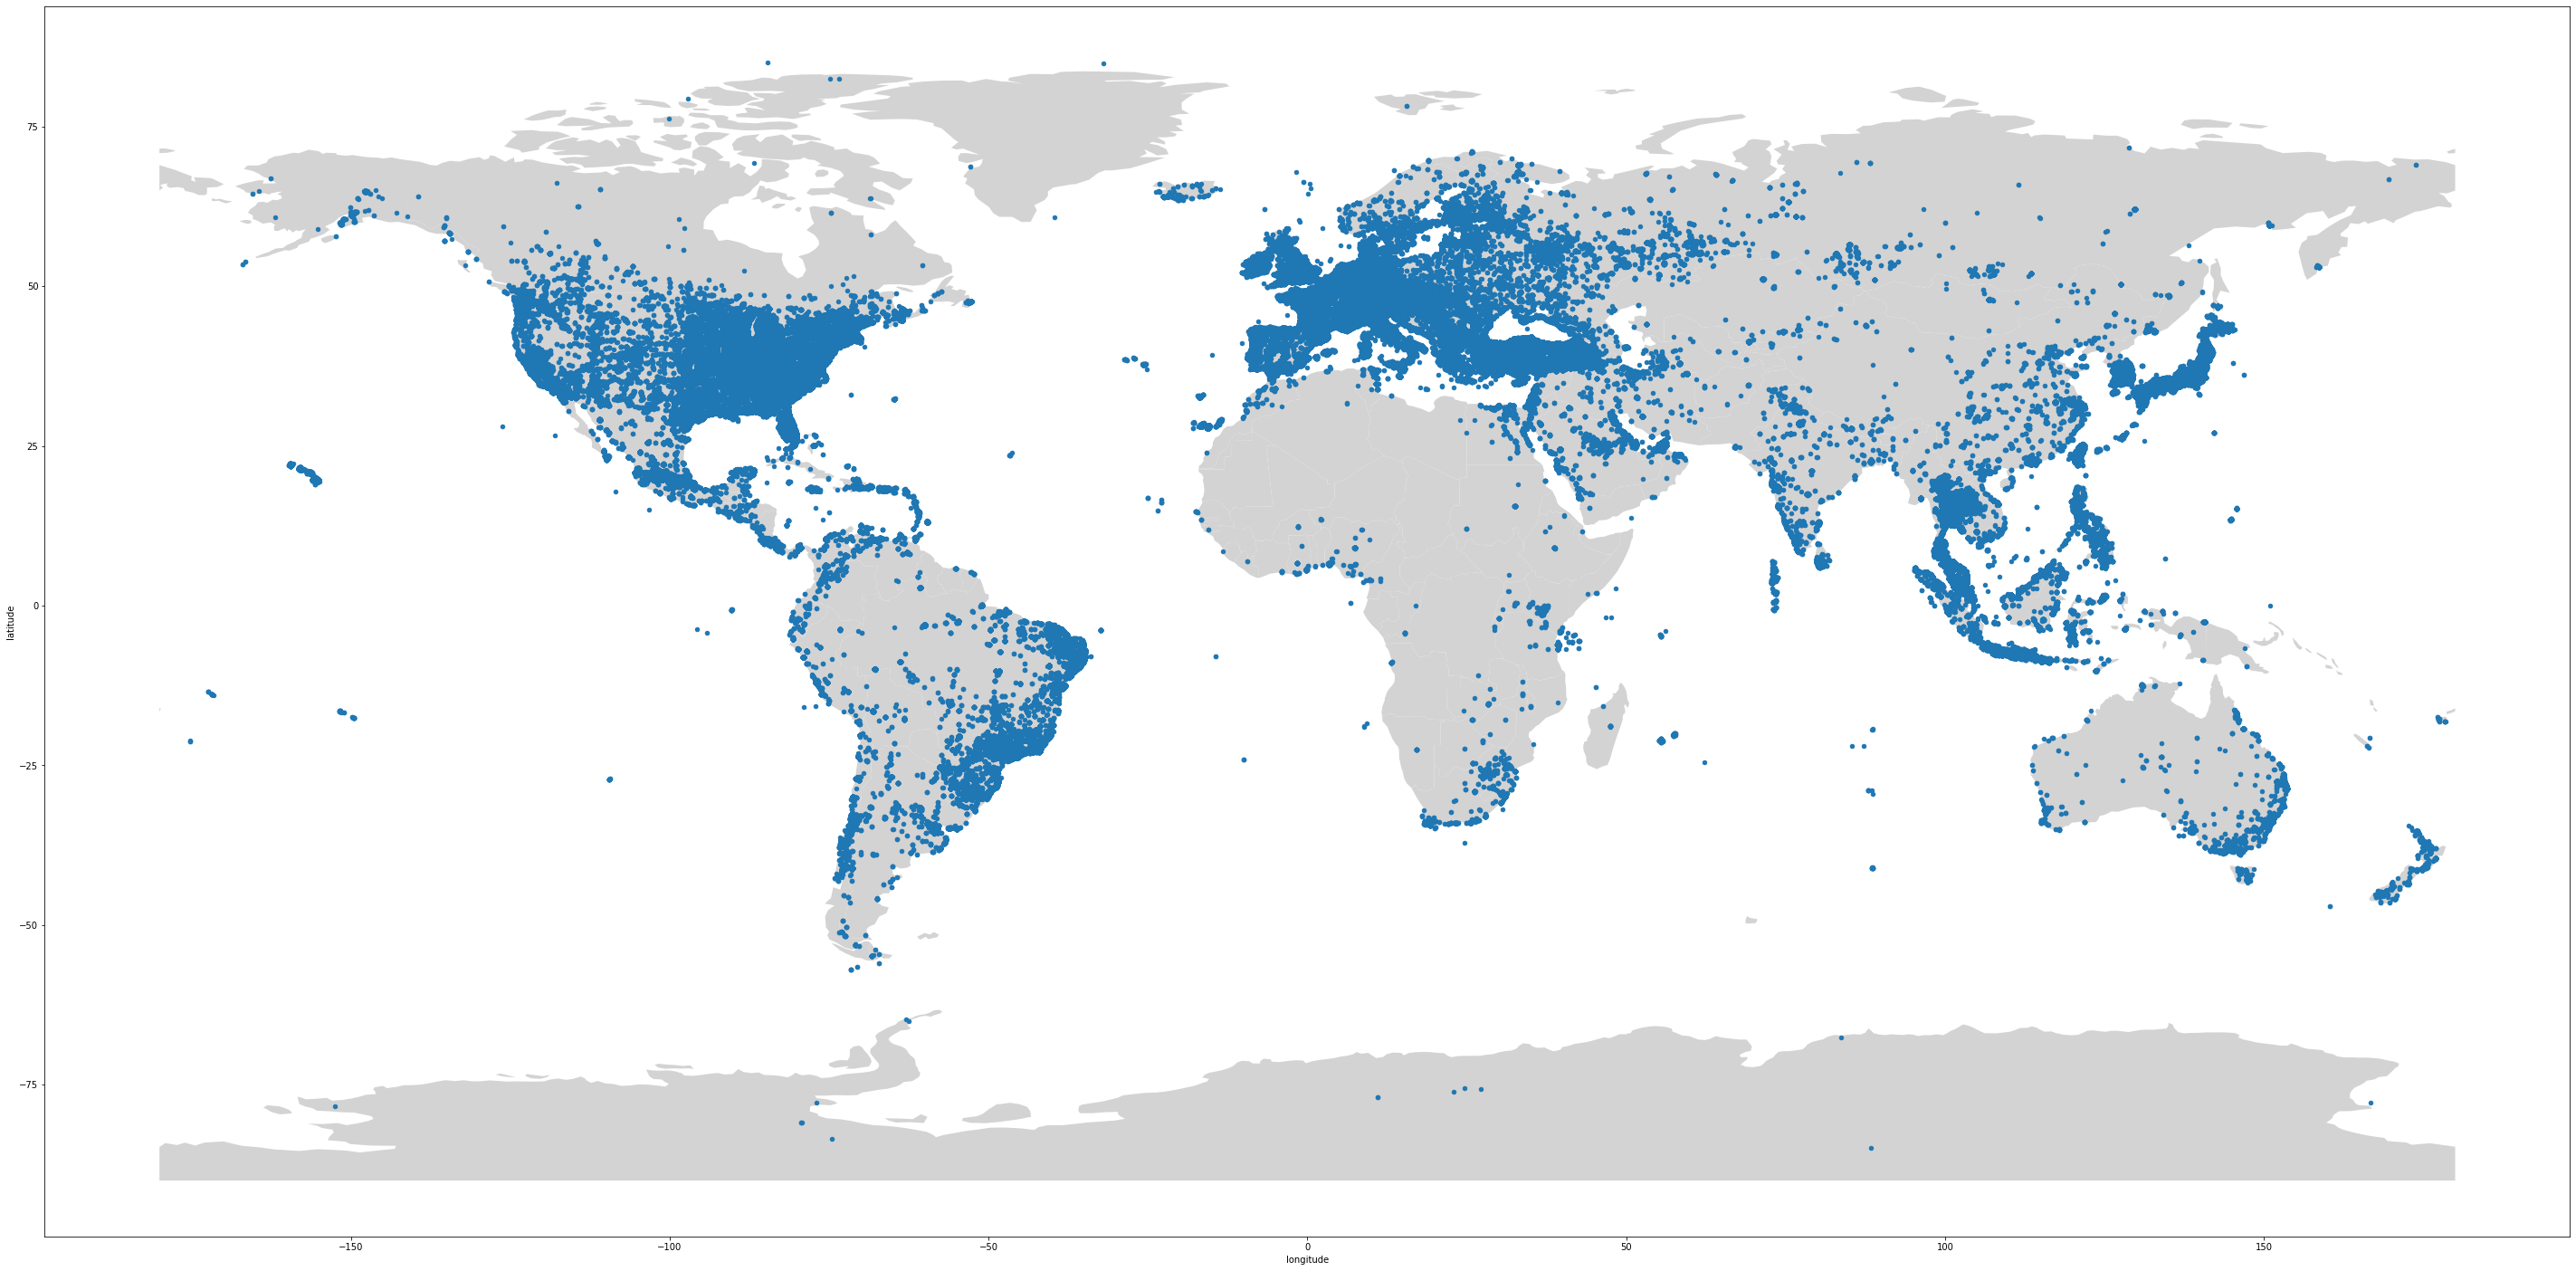

In [101]:
# Plot entries on map

import matplotlib.pyplot as plt
import geopandas as gpd

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(50, 30))

countries.plot(color="lightgrey", ax=ax)
df.plot(x="longitude", y="latitude", kind="scatter",
        colormap="YlOrRd", ax=ax);